In [101]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
import os
import cv2


In [102]:
os.chdir('/Users/raziel/Documents/Milestone_Hackathon_2019/Heatmap/')


list_of_centroids = [(550, 680), (400, 400), (875, 400), (1100, 580), (1850, 600), (1600, 250), (1100, 200)]

def draw_centroids(image, loc, color = None, size = None):
    for c in loc:
        cv2.circle(image, c, size, color, -1)
    return(image)


#2D Gaussian function
def twoD_Gaussian( x, y, xo, yo, sigma_x, sigma_y):
    a = 1./(2*sigma_x**2) + 1./(2*sigma_y**2)
    c = 1./(2*sigma_x**2) + 1./(2*sigma_y**2)
    g = np.exp( - (a*((x-xo)**2) + c*((y-yo)**2)))
    return g.ravel()


def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap


#Use base cmap to create transparent
mycmap = transparent_cmap(plt.cm.Reds) #Red colors 


# Import image and get x and y extents
I = Image.open('images/00001.jpg')
p = np.asarray(I).astype('float')

draw_centroids(p, list_of_centroids)


w, h = I.size
y, x = np.mgrid[0:h, 0:w]


#Plot image and overlay colormap
fig, ax = plt.subplots(1, 1)
ax.imshow(I)
Gauss = twoD_Gaussian( x, y, .5*x.max(), .4*y.max(), .1*x.max(), .1*y.max())
cb = ax.contourf(x, y, Gauss.reshape(x.shape[0], y.shape[1]), 15, cmap=mycmap)
plt.colorbar(cb)
plt.axis('off')
plt.show()
#plt.savefig('fig.heatmap.jpg')


TypeError: an integer is required (got type NoneType)

## Heatmap by coordinates

<IPython.core.display.Javascript object>


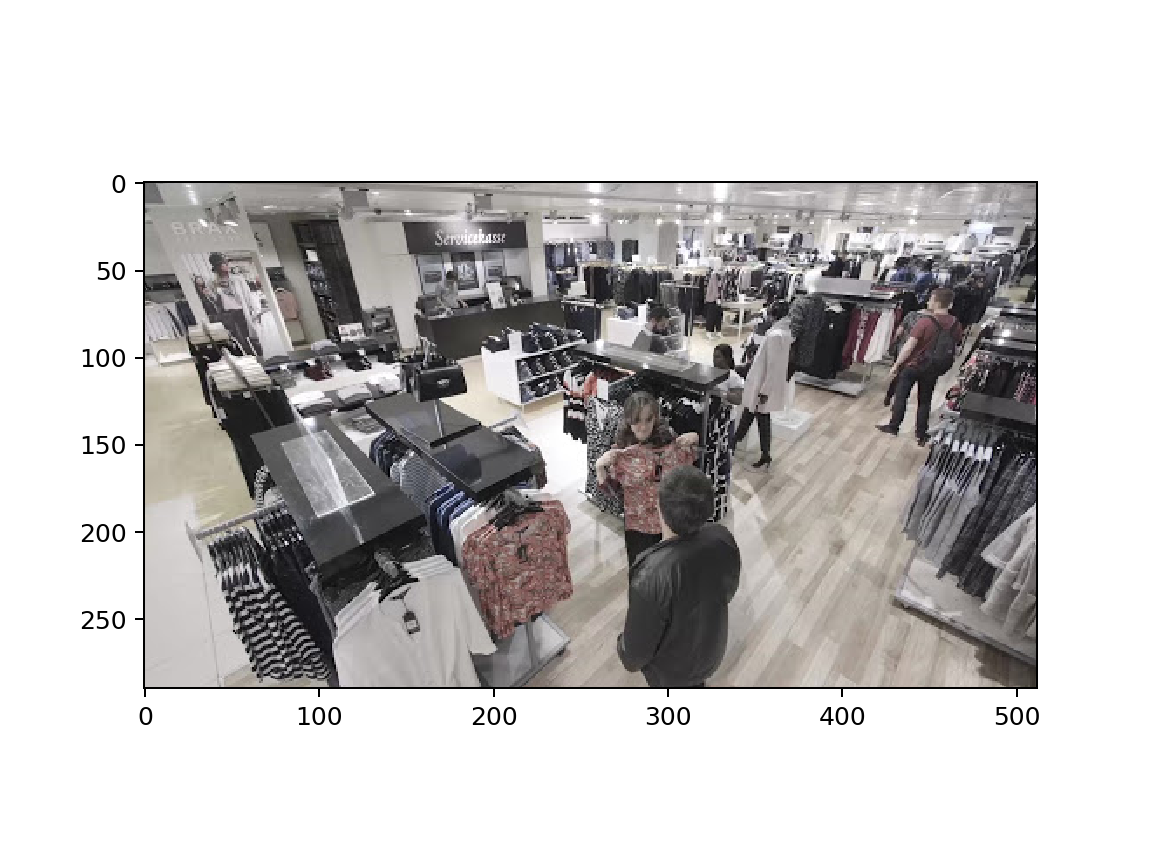

In [80]:


def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

#Use base cmap to create transparent
mycmap = transparent_cmap(plt.cm.Reds) #Red colors 
# Import image and get x and y extents
I = Image.open('images/00001.jpg')

fig, ax = plt.subplots(1, 1)
ax.imshow(I)


plt.show()



In [94]:
from abc import ABCMeta, abstractmethod
from functools import partial
import io
import os
import random

from matplotlib.colors import LinearSegmentedColormap
import numpy
from PIL import Image

try:
    from PySide import QtCore, QtGui
except ImportError:
    pass


def _img_to_opacity(img, opacity):
        img = img.copy()
        alpha = img.split()[3]
        alpha = alpha.point(lambda p: int(p * opacity))
        img.putalpha(alpha)
        return img

#_asset_file = partial(os.path.join, os.path.dirname(__file__), 'assets')
    
class Heatmapper:
    def __init__(self, point_diameter=50, point_strength=0.2, opacity=0.65,
                 colours='default',
                 grey_heatmapper='PIL'):
        """
        :param opacity: opacity (between 0 and 1) of the generated heatmap overlay
        :param colours: Either 'default', 'reveal',
                        OR the path to horizontal image which will be converted to a scale
                        OR a matplotlib LinearSegmentedColorMap instance.
        :param grey_heatmapper: Required to draw points on an image as a greyscale
                                heatmap. If not using the default, this must be an object
                                which fulfils the GreyHeatmapper interface.
        """

        self.opacity = opacity

        self._colours = None
        self.colours = colours

        if grey_heatmapper == 'PIL':
            self.grey_heatmapper = PILGreyHeatmapper(point_diameter, point_strength)
        elif grey_heatmapper == 'PySide':
            self.grey_heatmapper = PySideGreyHeatmapper(point_diameter, point_strength)
        else:
            self.grey_heatmapper = grey_heatmapper

    @property
    def colours(self):
        return self._colours

    @colours.setter
    def colours(self, colours):
        self._colours = colours

        if isinstance(colours, LinearSegmentedColormap):
            self._cmap = colours
        else:
            files = {
                'default': _asset_file('default.png'),
                'reveal': _asset_file('reveal.png'),
            }
            scale_path = files.get(colours) or colours
            self._cmap = self._cmap_from_image_path(scale_path)

    @property
    def point_diameter(self):
        return self.grey_heatmapper.point_diameter

    @point_diameter.setter
    def point_diameter(self, point_diameter):
        self.grey_heatmapper.point_diameter = point_diameter

    @property
    def point_strength(self):
        return self.grey_heatmapper.point_strength

    @point_strength.setter
    def point_strength(self, point_strength):
        self.grey_heatmapper.point_strength = point_strength

    def heatmap(self, width, height, points, base_path=None, base_img=None):
        """
        :param points: sequence of tuples of (x, y), eg [(9, 20), (7, 3), (19, 12)]
        :return: If base_path of base_img provided, a heat map from the given points
                 is overlayed on the image. Otherwise, the heat map alone is returned
                 with a transparent background.
        """
        heatmap = self.grey_heatmapper.heatmap(width, height, points)
        heatmap = self._colourised(heatmap)
        heatmap = _img_to_opacity(heatmap, self.opacity)

        if not (base_path or base_img):
            return heatmap

        background = Image.open(base_path) if base_path else base_img
        return Image.alpha_composite(background.convert('RGBA'), heatmap)

    def heatmap_on_img_path(self, points, base_path):
        width, height = Image.open(base_path).size
        return self.heatmap(width, height, points, base_path=base_path)

    def heatmap_on_img(self, points, img):
        width, height = img.size
        return self.heatmap(width, height, points, base_img=img)

    def _colourised(self, img):
        """ maps values in greyscale image to colours """
        arr = numpy.array(img)
        rgba_img = self._cmap(arr, bytes=True)
        return Image.fromarray(rgba_img)

    @staticmethod
    def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return LinearSegmentedColormap.from_list('from_image', colours)

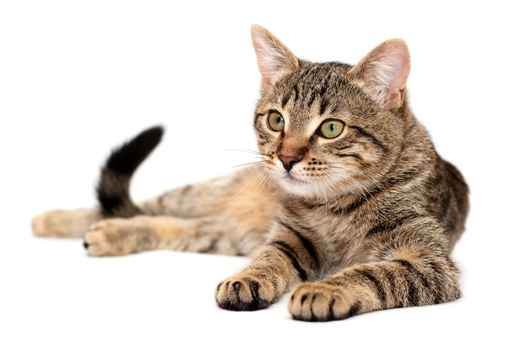

In [95]:
os.chdir('/Users/raziel/Documents/Milestone_Hackathon_2019/Heatmap/')

from PIL import Image

example_points = [(100, 20), (120, 25), (200, 50), (60, 300), (170, 250)]
example_img_path = 'images/cat.jpg'
example_img = Image.open(example_img_path)
example_img

In [96]:
heatmapper = Heatmapper()

NameError: name '_asset_file' is not defined